# Notebook to create plots showing example data signals

This notebook is initially planned to help in the creation of two types of data plots:
1. EMG signal time series over an arbitrary length of time (referred to as 'trace' plots)
2. EMG spike/burst waveforms, aligned and on top of one another (referred to as 'waveform' plots)


## Imports

In [21]:
import os 
import glob
import pickle

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from mosquito.process_abf import load_processed_data
from mosquito.read_photron import my_read_cih, my_read_mraw

## Params

In [32]:
# EXAMPLE DATA INFO
# define identifying info for which data files we'll use here (can also do case by case basis)
mosquito_example_folder = '29_20240530'
mosquito_example_axo = 3 

drosophila_example_folder = '35_20240701'
drosophila_example_axo = 0


In [33]:
# SAVE INFO
# where to save figures?
save_path = '/home/sam/Desktop'
trace_save_str = 'trace'  # header for filenames of trace plots
waveform_save_str = 'waveform'  # header for filenames of wavefor plots

# should we save plots?
save_trace_flag = False # if True, save the example emg trace plot; if False, don't
save_waveform_flag = False  # if True, save the example emg waveform plot; if False, don't

# how should figures be saved? (resolution, file format, etc)
save_dpi = 500 
save_ext = '.png'  # '.png'


In [34]:
# PLOT PARAMETERS
plot_type = 'paper'  # 'paper' or 'powerpoint'

# # generate a dictionary called fig params that encodes information we care about
if plot_type == 'powerpoint':
    fontsize = 14
    figsize = (10,7.5)
    subplot_left = 0.15
    subplot_right = 0.85
    subplot_top = 0.8
    subplot_bottom = 0.15
elif plot_type == 'paper':
    fontsize = 8
    figsize = (8,8)
    subplot_left = 0.2
    subplot_right = 0.8
    subplot_top = 0.8
    subplot_bottom = 0.2

fig_params = {
      'font.family' : 'sans-serif',
      'font.serif' : 'Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman',
      'font.sans-serif' : 'arial, Helvetica, Avant Garde, Computer Modern Sans serif',
      'font.cursive' : 'Zapf Chancery',
      'font.monospace' : 'Courier, Computer Modern Typewriter',
      'font.size' : fontsize,
      'axes.labelsize': fontsize,
      'axes.linewidth': 1.0,
      'xtick.major.width': 1,
      'xtick.minor.width': 1,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'figure.figsize': figsize,
}
rcParams.update(fig_params) 

## Functions

In [35]:
def plot_emg_trace(data, time_range, scalebar_size=1, figsize=(2,1), ylim=None,
                   time_units='s', fig_params=None):
    """
    Function to take in a data dictionary for a single fly and make
    a zoomed-out plot of the emg trace

    Args:
        - data: dictionary loaded from pickled *_processed.p file
        - time_window: tuple giving the range of data to plot 
            (e.g. (4, 8) will plot between t=4 and t=8 seconds)
        - scalebar_size: size (duration) of scalebar, in seconds
        - figsize: tuple giving (width, height) of figure in inches 
            (passed to pyplot.subplots)
        - ylim: tuple giving y axis limits. If None, use auto scale
        - time_units: units of time values in data. should be 's'
        - fig_params: dictionary containing plot params; under 
            construction

    Returns:
        - fig, ax
    """
    # read out data from dict
    t = data['time']
    emg = data['emg']
    
    # plot params
    # TODO: move this to params dictionary
    linewidth = 0.5 
    scalebar_linewidth = 1.5
    color = 'k'
    
    # initialize figure
    fig, ax = plt.subplots(figsize=figsize)

    # restrict time domain to time_range
    mask = (t >= time_range[0]) & (t <= time_range[-1])

    # plot. Note that we're subtracting off the initial time so it always
    # starts at t=0
    ax.plot(t[mask] - time_range[0],
             emg[mask],
             color=color,
             lw=linewidth)

    # -----------------------------------------
    # axis properties
    # restrict x range
    ax.set_xlim([0, time_range[1] - time_range[0]])

    # restrict y range?
    if ylim is not None:
        ax.set_ylim(ylim)
        
    # add scalebar
    ax.spines['bottom'].set_bounds([0, scalebar_size])
    ax.spines['bottom'].set_linewidth(scalebar_linewidth)
    ax.spines['bottom'].set_position(('outward', 3))

    # label scalebar. 
    ax.set_xticks([scalebar_size/2])
    ax.set_xticklabels([f'{scalebar_size} {time_units}'])
    ax.tick_params(length=0)
    
    # remove other axis lines
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)

    # remove y ticks
    ax.set_yticks([])
    
    return fig, ax



In [36]:
def realign_spikes(spikes, spike_idx, emg, window, thresh_factor=0.5):
    """
    Helper function to align spike waveform traces based on when they
    first cross a given threshold

    Args:
        spikes: list containing isolated spike waveform arrays (data['spikes'])
        spike_idx: list of indices of detected spikes (data['spike_idx'])
        emg: array containing raw emg data (data['emg'])
        window: int giving the size of spike window to consider
        thresh_factor: number to multiply by mean spike height to get 
            threshold whose crossing we align to

    Returns:
        spikes_realigned:  list containing isolated REALIGNED spike waveforms
        spike_realigned_idx: list of indices of REALIGNED spikes
    
    """
    # calculate thresh based on spike height and thresh_factor
    mean_spike_height = np.mean(np.max(np.vstack(spikes), axis=1))
    thresh = thresh_factor*mean_spike_height  # align waveforms to when spikes cross thresh

    # loop through and get aligned spike arrays
    spikes_realigned = list()
    spike_realigned_idx = list()

    for idx in spike_idx:
        # get spike in current window
        idx_range = np.arange(idx - window, idx + window)
        spike = emg[idx_range]
    
        # subtract off value at initial time point
        spike -= spike[0]
    
        # find first instance of thresh crossing
        try:
            thresh_idx = np.where(spike > thresh)[0][0]
        except IndexError:
            continue
            
        thresh_idx += (idx - window)
        spike_realigned_idx.append(thresh_idx)
    
        # get spike in this new window
        spike_new = emg[slice(thresh_idx - window, thresh_idx + 2*window)]
        spikes_realigned.append(spike_new)

    return spikes_realigned, spike_realigned_idx
    

In [37]:
def plot_emg_waveform(data, scalebar_size=0.01, figsize=(2,1), ylim=None, xlim=None, 
                      time_units='s', fig_params=None):
    """
    Function to take in a data dictionary for a single fly and make
    a plot showing extracted spike/burst waveforms

    Args:
        - data: dictionary loaded from pickled *_processed.p file
        - scalebar_size: size (duration) of scalebar, in seconds
        - figsize: tuple giving (width, height) of figure in inches 
            (passed to pyplot.subplots)
        - ylim: tuple giving y axis limits. If None, use auto scale
        - xlim: tuple giving x axis limits. If None, use auto scale
        - time_units: units of time values in data. should be 's'
        - fig_params: dictionary containing plot params; under 
            construction

    Returns:
        - fig, ax
    """
    # plot params
    linewidth = 0.1 
    alpha = 0.2 
    scalebar_linewidth = 1.5
    color = 'k'

    # read out signals from data dictionary
    window = round(data['params']['emg_window']/2)
    spikes = data['spikes']
    spike_idx = data['spike_idx']
    emg = data['emg']
    fs = data['sampling_freq']

    # realign spikes based on raw data (they are stored based on filtered alignment)
    spikes_realigned, _ = realign_spikes(spikes, spike_idx, emg, window)

    # make figure
    fig, ax = plt.subplots(figsize=figsize)

    # define time range
    t_win = (1/fs)*(np.arange(spikes_realigned[0].shape[0]) - window)
    t_win -= t_win[0]
    
    # plot spikes
    for spike in spikes_realigned:
        ax.plot(t_win, spike - np.mean(spike[:window]), '-', color=color,
                alpha=alpha, lw=linewidth)

    # ---------------------------------------
    # axis formatting

    # set x limits
    if xlim is None:
        xmin = t_win[0]
        xmax = t_win[-1]
        
    ax.set_xlim([xmin, xmax])
    
    # add scalebar
    ax.spines['bottom'].set_bounds([xmin, xmin + scalebar_size])
    ax.spines['bottom'].set_linewidth(scalebar_linewidth)
    ax.spines['bottom'].set_position(('outward', 3))
    
    # label scalebar
    if (scalebar_size < 1) and (time_units == 's'):
        # switch  to milliseconds if we're using small values
        scalebar_label_val = round(1000*scalebar_size)
        scalebar_label = f'{scalebar_label_val} ms'
    else:
        scalebar_label = f'{scalebar_size} {time_units}'

    ax.set_xticks([scalebar_size/2])
    ax.set_xticklabels([scalebar_label], fontsize='small')
    ax.tick_params(length=0)

    # remove y ticks
    ax.set_yticks([])
    
    # remove other axis lines
    for spine in ['right', 'top', 'left']:
        ax.spines[spine].set_visible(False)
    
    return fig, ax 


## Make an example trace plot by loading data and using 'plot_emg_trace'

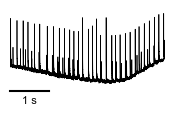

In [38]:
# load an example data file (can use one defined above or enter in new one)
data_folder = mosquito_example_folder
axo_num = mosquito_example_axo 

data = load_processed_data(data_folder, axo_num)

# plot options
time_range = (4, 8)
scalebar_size = 1
figsize = (2, 1)  # (2, 1)

# make figure
fig, ax = plot_emg_trace(data, time_range, scalebar_size, figsize=figsize)

# save?
if save_trace_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename = f'{trace_save_str}_{data_folder}_{axo_num:02d}{save_ext}'

    # save
    # fig.tight_layout()
    # bbox_tup = (0,-10,1,1)
    # save_bbox = fig.bbox_inches.from_bounds(*bbox_tup)
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')



## Make another example trace plot for a Drosophila trial

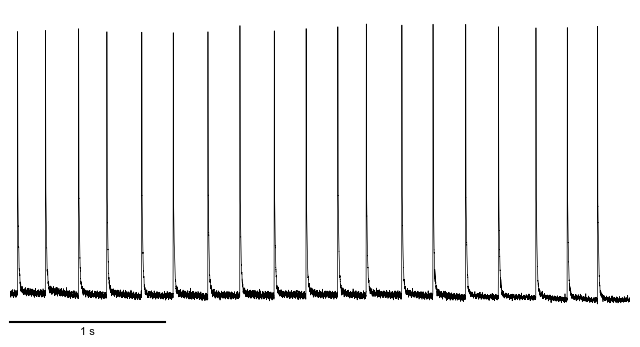

In [39]:
# load an example data file
data_folder = drosophila_example_folder
axo_num = drosophila_example_axo

data = load_processed_data(data_folder, axo_num)

# plot options
time_range = (2, 6)
scalebar_size = 1
figsize = (8, 4)  # (2, 1)

# make figure
fig, ax = plot_emg_trace(data, time_range, scalebar_size, figsize=figsize)

# save?
if save_trace_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename = f'{trace_save_str}_{data_folder}_{axo_num:02d}{save_ext}'

    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')


## Make a plot of aligned waveform traces for an example mosquito

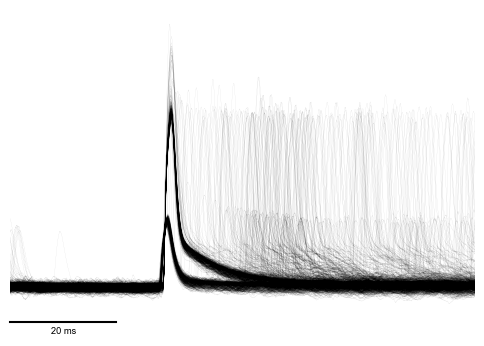

In [40]:
# load an example data file (can use one defined above or enter in new one)
data_folder = mosquito_example_folder
axo_num = mosquito_example_axo 

data = load_processed_data(data_folder, axo_num)

# plot options
scalebar_size = 0.02
figsize = (6, 4)  # (1.5, 1)

# make figure
fig, ax = plot_emg_waveform(data, scalebar_size=scalebar_size, figsize=figsize)

# save?
if save_waveform_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename = f'{waveform_save_str}_{data_folder}_{axo_num:02d}{save_ext}'

    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')



## Make a plot of aligned waveform traces for an example mosquito

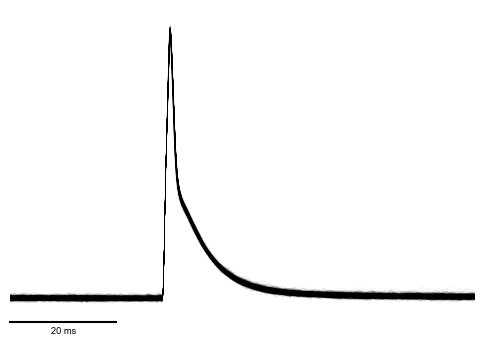

In [41]:
# load an example data file (can use one defined above or enter in new one)
data_folder = drosophila_example_folder
axo_num = drosophila_example_axo 

data = load_processed_data(data_folder, axo_num)

# plot options
scalebar_size = 0.02
figsize = (6, 4)  # (1.5, 1)

# make figure
fig, ax = plot_emg_waveform(data, scalebar_size=scalebar_size, figsize=figsize)

# save?
if save_waveform_flag:
    # make the filename of the figure reflect which data file it's from
    save_filename = f'{waveform_save_str}_{data_folder}_{axo_num:02d}{save_ext}'

    # save
    fig.savefig(os.path.join(save_path, save_filename), dpi=save_dpi, bbox_inches='tight')


In [75]:
# load some data
example_folder = '31_20240611'
example_axo = 4

data = load_processed_data(example_folder, example_axo)

# keys for info in data dictionary:
print('Key options we can use:')
print('-------------------------')
for key in data.keys():
    print(key)

Key options we can use:
-------------------------
sampling_freq
filepath
units
header
time
emg
cam
mic
odor
species
muscle_type
filename
mic_filt
mic_phase
wbf_mean
wbf
flying_idx
emg_filt
spikes
spike_t
spike_idx
spike_rate
params


In [79]:
# example reading out a data set
data['wbf']

array([169.1817, 169.1817, 169.1817, ..., 173.2313, 173.2311, 173.2308])

Text(0, 0.5, 'wingbeat frequency (Hz)')

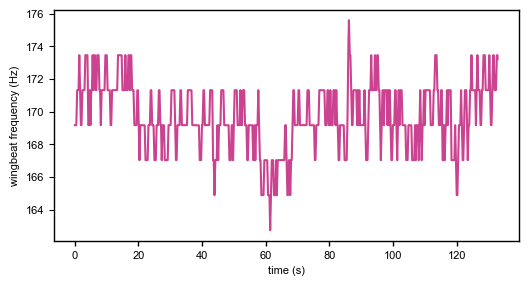

In [97]:
# playing with axis properties
fig, ax = plt.subplots(figsize=(6,3))

x = data['time']  # np.arange(10)
y = data['wbf']  # 3*np.arange(10)

ax.plot(x, y,
        color='#CB4290',  # for color options, see https://matplotlib.org/1.4.1/api/colors_api.html
        linestyle='-',   # linestyle options are https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
        marker='None',     # marker options https://matplotlib.org/stable/api/markers_api.html
       )

# set labels
ax.set_xlabel('time (s)')
ax.set_ylabel('wingbeat frequency (Hz)')

# lets say we want to remove everything from x axis:
# ax.spines['bottom'].set_visible(False)  # this removes box line only for bottom. could replace 'bottom' with 'top' 'left' or 'right'
# ax.set_xticks([])  

{'whiskers': [<matplotlib.lines.Line2D at 0x7a2eab59b140>,
 'caps': [<matplotlib.lines.Line2D at 0x7a2eab59b710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a2eab59af30>],
 'medians': [<matplotlib.lines.Line2D at 0x7a2eab59bb90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a2eab59bec0>],
 'means': []}

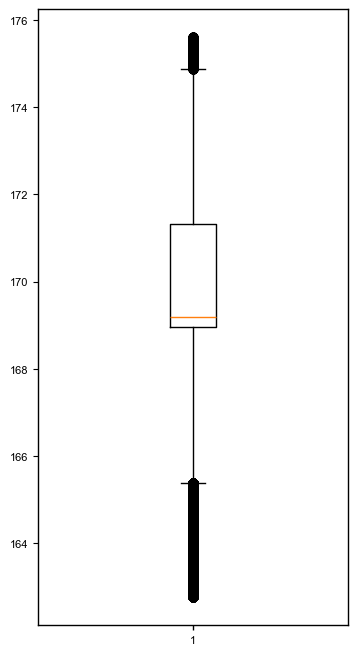

In [100]:
# now let's make a box and whisker plot
fig, ax = plt.subplots(figsize=(4,8))

# read out data (wingbeat frequency)
wbf = data['wbf'] 

# make a boxplot of it
ax.boxplot(wbf)


In [91]:
# if we want to get mean or median from data:
# first read out array from the dictionary called data. here we'll grab the wingbeat frequency and assign it to a variable called wbf 
wbf = data['wbf'] 

# use numpy to calculate mean of the data. to use any numpy function, we type "np.(function name)" where the function name can be lots of 
# different options. several are listed here: https://numpy.org/doc/stable/reference/routines.statistics.html
wbf_mean = np.mean(wbf)
print('mean: ', wbf_mean)

# similarly, to get median, we do:
wbf_median = np.median(wbf)
print('median: ', wbf_median)

# similarly, to get standard deviation, we do:
wbf_std = np.std(wbf)
print('standard deviation: ', wbf_std)

mean:  169.7093174267894
median:  169.18170166015625
standard deviation:  1.9589544114617126
